# Analyzing Colllege Scorecard Data

Malcolm Devoe <br />
Digital Humanities 101 <br />
Evan Muzzall <br />
July 2, 2020

## Introduction

In 2017, just before he left office, President Obama announced that Harvard University’s graduate theatre program was failing. This was due to the fact that an average graduate made around $35,000 ten years after graduation, but was stuck with almost a hundred thousand dollars in debt. According to the Department of Education, this meant that the average graduate had to spend half their discretionary income on interest for their loans, a statistic that seemed more akin to a predatory for-profit college than a world renowned university. 

In response, Harvard decided to shut the program to new applicants for three years. The data for the shocking announcement came from a different program, also begun under President Obama. In 2015, the Department of Education released a “college scorecard” that contained a wealth of data on colleges. The ongoing dataset included information about a college’s acceptance rate, average loan taken to obtain a degree, graduation rate, loan repayment rate, student earnings 10 years after graduation, and dozens of other fields about the degree programs offered and financial outcomes of students. The dataset covers essentially all of America’s private, public, and for-profit colleges from 1996 through 2018.

# Research Question and Relevance

My research question is: How are factors that are roughly correlated with college prestige (eg. Acceptance rate, average SAT score, students from high income backgrounds, faculty salaries) related to financial outcomes for students (eg. earnings 10 years after graduation)?

Various organizations have already used this data to create college rankings, such as the Brookings Institution (see image below). But many of these analyses effectively hide the underlying data from the reader, and boil down their analyses to one number only. I think that analyzing the data in a more transparent way will be useful and interesting, and will help motivate further research.

<img src="brookings.png" alt="drawing" width="800"/>

# Methods and Materials

To recap, I want to examine which factors best predict a student's future earnings. Perhaps students from wealthy backgrounds make a lot of money no matter which college they attend. Or maybe a student's SAT scores are a better predictor of future earnings. To find which features are the best predictors, I tried three different sklearn models: Linear, Decision Tree, Random Forest, and Ada Boost. I chose these models because they are generally recognized as solid model choices that can give good results

**Linear**: This model assumes the relationship between the given data and the outcome (earnings) is linear. So a higher SAT score will directly translate to higher earnings, for example

**Decision Tree**: This model makes decisions based on whether certain features are above or below certain amounts. The max_depth controls the number of decisions, so if max_depth is one, then the decision tree will look at each row and choose a field and make one dicision based on one field. If max_depth is 2, then after making the first decision, the model will choose another number to make another decision on.

**Random Forest**: This model is a bunch of decision trees, and the model will take the average of all the decision trees' predicitons to output its predicted value

**Adaptive Boosting**: This model is very advanced. It makes many decision trees. As new trees are trained, the samples that are wrong are weighted more so that the new learners try to focus more on predicting those samples. In the end the "weak learners" (decision trees are referred to as weak learners in this case) are combined and form a "strong learner". 

In [1529]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
plt.style.use("fivethirtyeight")

In [1530]:
data = pd.read_csv("CollegeScorecard_Raw_Data/MERGED2012_13_PP.csv")

/Users/malcolmdevoe/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1575,1729,1909,1910,1911,1912,1913) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1531]:
print(data.shape)
data.head()

(7862, 1986)


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMENRUP_PARTTIME_POOLED_SUPP,FTFTPCTPELL,FTFTPCTFLOAN,UG12MN,G12MN,SCUGFFN,POOLYRS_FTFTAIDPCT,FTFTPCTPELL_POOLED_SUPP,FTFTPCTFLOAN_POOLED_SUPP,SCUGFFN_POOLED
0,100636,1230800,12308,Community College of the Air Force,Montgomery,AL,36114-3011,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,0.7874,0.8446,4582.0,975.0,856.0,NaN,NaN,NaN,NaN
2,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,0.3726,0.5450,12962.0,7930.0,1578.0,NaN,NaN,NaN,NaN
3,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,NaN,0.8750,0.8750,522.0,581.0,8.0,NaN,NaN,NaN,NaN
4,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,NaN,0.3160,0.4126,6983.0,2026.0,652.0,NaN,NaN,NaN,NaN


I am focusing on these data fields:

INSTNM is Institution Name. This field is not included in the machine learning models.

*MN_EARN_WNE_P10* is **mean earnings** of students working and not enrolled 10 years after entry

*MD_FAMINC* is the **median family income** of students' families

*ADM_RATE* is the **admission rate**

*INEXPFTE* is the **instructional expenditures** per full-time equivalent student

*PFTFAC* is the proportion of **faculty that is full time**

*NPT4_PUB* is **average net cost for public** schools

*NPT4_PRIV* is **average net cost for private** schools

*GRAD_DEBT_MDN* is **median graduation debt** among students who **finish their degree**

*WDRAW_DEBT_MDN* is **median graduation debt** among students who **do not finish their degree**

*PAR_ED_PCT_1STGEN* is percentage of students who are **first generation**

*HIGHDEG* is the **highest degree awarded** by the institution (associate's, bachelor's, etc)

*AVGFACSAL* is the **average faculty salary**

*PCIP14* **percentage of degrees awarded that are engineering**

*PCIP52* **percentage of degrees awarded that are business**

*UGDS* is the **number of undergrads** enrolled

### Selecting the fields above from the 1900 fields available:

In [1532]:
some_fields = data[["INSTNM", "MN_EARN_WNE_P10", "ADM_RATE", "SAT_AVG", "HIGHDEG", "MD_FAMINC", "GRAD_DEBT_MDN", "WDRAW_DEBT_MDN", "NPT4_PUB", "NPT4_PRIV", "PAR_ED_PCT_1STGEN", "CONTROL", "PFTFAC", "PCIP14", "PCIP52", "INEXPFTE", "AVGFACSAL", "UGDS"]]

I discovered that some fields have strange values: for example for five colleges the average net cost was negative.

In [1533]:
some_fields[some_fields["NPT4_PRIV"] < 0]

,INSTNM,MN_EARN_WNE_P10,ADM_RATE,SAT_AVG,HIGHDEG,MD_FAMINC,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,NPT4_PUB,NPT4_PRIV,PAR_ED_PCT_1STGEN,CONTROL,PFTFAC,PCIP14,PCIP52,INEXPFTE,AVGFACSAL,UGDS
1455,Berea College,36600,0.3182,1134.0,3,23090,5844,3314,NaN,-19360.0,0.4382566586,2,0.8258,0.0,0.1262,14692.0,7238.0,1604.0
5442,HRDE-Stanley Technical Institute-Parkersburg,22600,NaN,NaN,1,0,PrivacySuppressed,PrivacySuppressed,NaN,-1710.0,PrivacySuppressed,2,NaN,0.0,0.0000,8815.0,NaN,5.0
5921,In Session Arts of Cosmetology Beauty School,PrivacySuppressed,NaN,NaN,1,10518,PrivacySuppressed,PrivacySuppressed,NaN,-61.0,0.780141844,3,NaN,0.0,0.0000,1168.0,NaN,73.0
6645,South Texas Training Center,NaN,NaN,NaN,1,13012.5,3500,1813,NaN,-264.0,0.6810810811,3,NaN,0.0,0.0000,2720.0,NaN,47.0
7313,Lil Lou's Beauty and Barber College LLC,NaN,NaN,NaN,1,0,PrivacySuppressed,PrivacySuppressed,NaN,-342.0,0.4528301887,3,NaN,0.0,0.0000,4313.0,NaN,44.0


### "Privacy Surpressed"

Some colleges are very small, and revealing this data would violate student privacy, so instead of a value they have "Privacy Surpressed" as a value. I change this string to nan:

In [1534]:
for col in some_fields.columns:
    if col != "INSTNM":
        some_fields[col] = pd.to_numeric(some_fields[col], errors='coerce')

/Users/malcolmdevoe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1535]:
count = 0
for index, row in some_fields.iterrows():
    for item in row:
        if item == 'PrivacySuppressed':
            count += 1
assert count == 0

### One Hot Encoding:

I was getting strange results until I learned that any numerical data is compared to any other in the column. So if there is a column with the values 0, 1, or 2 for public, private, and for-profit, then a model will assume that there is an ordering to the numbers. So "2" is viewed as more important than 1, because it is a larger number. The solution is apparently called "one hot encoding", where you take the column of 0, 1, and 2 and turn it into three columns, where the value is 1 if a school is public and 0 otherwise, for example.

In [1536]:
some_fields = pd.concat([some_fields, pd.get_dummies(some_fields["CONTROL"], prefix="CONTROL")], axis=1).drop("CONTROL", axis=1)
some_fields = pd.concat([some_fields, pd.get_dummies(some_fields["HIGHDEG"], prefix="HIGHDEG")], axis=1).drop("HIGHDEG", axis=1)
some_fields.rename(columns={'CONTROL_1':'PUBLIC',
                            'CONTROL_2':'PRIVATE',
                            'CONTROL_3':'FORPROFIT',
                            'HIGHDEG_0':'NO_DEGREE',
                            'HIGHDEG_1':'CERTIFICATE',
                            'HIGHDEG_2':'ASSOCIATE',
                            'HIGHDEG_3':'BACHELOR',
                            'HIGHDEG_4':'GRADUATE'}, inplace=True)
some_fields.head()

,INSTNM,MN_EARN_WNE_P10,ADM_RATE,SAT_AVG,MD_FAMINC,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,NPT4_PUB,NPT4_PRIV,PAR_ED_PCT_1STGEN,...,AVGFACSAL,UGDS,PUBLIC,PRIVATE,FORPROFIT,NO_DEGREE,CERTIFICATE,ASSOCIATE,BACHELOR,GRADUATE
0,Community College of the Air Force,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,1,0,0,1,0,0,0,0
1,Alabama A & M University,35000.0,0.5438,847.0,21285.0,28453.0,9500.0,11726.0,NaN,0.369586,...,6678.0,4081.0,1,0,0,0,0,0,0,1
2,University of Alabama at Birmingham,46300.0,0.7223,1107.0,33106.0,18750.0,7500.0,15123.0,NaN,0.345967,...,9650.0,11014.0,1,0,0,0,0,0,0,1
3,Amridge University,44800.0,NaN,NaN,17208.0,19772.5,5423.0,NaN,6927.0,0.494318,...,3635.0,338.0,0,1,0,0,0,0,0,1
4,University of Alabama in Huntsville,50400.0,0.7766,1162.0,31502.0,20750.0,7500.0,11160.0,NaN,0.324873,...,8923.0,5703.0,1,0,0,0,0,0,0,1


Also, the net price for public schools column and the net price for private schools column have no overlap between eachother, since every college is either public or private. So I combine them into one column to ensure that the table has fewer missing "nan" values

In [1537]:
assert len(some_fields[(~some_fields.NPT4_PUB.isnull() & ~some_fields.NPT4_PRIV.isnull())]) == 0

In [1538]:
some_fields["COST"] = some_fields["NPT4_PUB"].fillna(0) + some_fields["NPT4_PRIV"].fillna(0) #Fill nan with 0 instead
some_fields = some_fields.drop("NPT4_PUB", axis=1)
some_fields = some_fields.drop("NPT4_PRIV", axis=1)

In [1539]:
print(some_fields.shape)
some_fields.head()

(7862, 23)


,INSTNM,MN_EARN_WNE_P10,ADM_RATE,SAT_AVG,MD_FAMINC,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,PAR_ED_PCT_1STGEN,PFTFAC,PCIP14,...,UGDS,PUBLIC,PRIVATE,FORPROFIT,NO_DEGREE,CERTIFICATE,ASSOCIATE,BACHELOR,GRADUATE,COST
0,Community College of the Air Force,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,0,0,1,0,0,0,0,0.0
1,Alabama A & M University,35000.0,0.5438,847.0,21285.0,28453.0,9500.0,0.369586,0.7509,0.1372,...,4081.0,1,0,0,0,0,0,0,1,11726.0
2,University of Alabama at Birmingham,46300.0,0.7223,1107.0,33106.0,18750.0,7500.0,0.345967,0.9161,0.0578,...,11014.0,1,0,0,0,0,0,0,1,15123.0
3,Amridge University,44800.0,NaN,NaN,17208.0,19772.5,5423.0,0.494318,0.6543,0.0000,...,338.0,0,1,0,0,0,0,0,1,6927.0
4,University of Alabama in Huntsville,50400.0,0.7766,1162.0,31502.0,20750.0,7500.0,0.324873,0.8495,0.2648,...,5703.0,1,0,0,0,0,0,0,1,11160.0


Models apparently cannot handle missing values. So I have to drop any row that has a missing value. This is actually not too big of a deal, since all large and notable colleges have all data available. The dataset went from 7862 colleges to 1336 colleges. But every college that a person has ever heard of will probably still be in the dataset. The US has a large number of very small private colleges that have missing data.

In [1540]:
some_fields = some_fields[some_fields.isnull().sum(axis=1) == 0]
print(some_fields.shape)

(1336, 23)


In [1541]:
some_fields.head()

,INSTNM,MN_EARN_WNE_P10,ADM_RATE,SAT_AVG,MD_FAMINC,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,PAR_ED_PCT_1STGEN,PFTFAC,PCIP14,...,UGDS,PUBLIC,PRIVATE,FORPROFIT,NO_DEGREE,CERTIFICATE,ASSOCIATE,BACHELOR,GRADUATE,COST
1,Alabama A & M University,35000.0,0.5438,847.0,21285.0,28453.0,9500.0,0.369586,0.7509,0.1372,...,4081.0,1,0,0,0,0,0,0,1,11726.0
2,University of Alabama at Birmingham,46300.0,0.7223,1107.0,33106.0,18750.0,7500.0,0.345967,0.9161,0.0578,...,11014.0,1,0,0,0,0,0,0,1,15123.0
4,University of Alabama in Huntsville,50400.0,0.7766,1162.0,31502.0,20750.0,7500.0,0.324873,0.8495,0.2648,...,5703.0,1,0,0,0,0,0,0,1,11160.0
5,Alabama State University,29400.0,0.4604,827.0,19134.0,30458.5,9250.5,0.403284,0.6434,0.0000,...,5123.0,1,0,0,0,0,0,0,1,11029.0
6,The University of Alabama,48600.0,0.5308,1172.0,57475.5,22500.0,6500.0,0.264248,0.7228,0.0745,...,27364.0,1,0,0,0,0,0,0,1,18526.0


In [1542]:
names = some_fields["INSTNM"]
some_fields_with_name = some_fields
some_fields = some_fields.drop("INSTNM", axis=1)

# Results

In [1543]:
import sklearn as sk
from sklearn.model_selection import train_test_split

In [1544]:
def report_rmse(model, X_train, y_train, X_test, y_test):
    model_train_predictions = model.predict(X_train)
    model_train_rmse = np.sqrt(np.mean((y_train - model_train_predictions)**2))
    
    model_test_predictions = model.predict(X_test)
    model_test_rmse = np.sqrt(np.mean((y_test - model_test_predictions)**2))
    return model_train_rmse, model_test_rmse

The function above takes in a model and returns the root mean squared error of the predictions. Since I am trying to predict 10-year earnings, I like rmse because it tells me how far off my predictions are from the actual values, in dollars. Below, I separate the data into training and testing data:

In [1545]:
labels = some_fields['MN_EARN_WNE_P10']
inputs = some_fields[some_fields.columns.difference(['MN_EARN_WNE_P10'])]

In [1546]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, train_size=0.80)

/Users/malcolmdevoe/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


This is the **linear model**:

In [1547]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression().fit(X_train, y_train)
print(report_rmse(linear_model, X_train, y_train, X_test, y_test))
print(linear_model.score(X_test, y_test))

(6513.239217975518, 5807.78263647617)
0.8140241486341951


In [1548]:
pd.DataFrame({"Weight":linear_model.coef_.round(2), "Min":X_train.min(axis=0), "Max":X_train.max(axis=0)})

,Weight,Min,Max
ADM_RATE,-2398.32,0.058100,1.00000
ASSOCIATE,4008.39,0.000000,1.00000
AVGFACSAL,2.88,1781.000000,17435.00000
BACHELOR,182.57,0.000000,1.00000
CERTIFICATE,-0.00,0.000000,0.00000
COST,0.14,-19360.000000,45752.00000
FORPROFIT,6845.04,0.000000,1.00000
GRADUATE,349.40,0.000000,1.00000
GRAD_DEBT_MDN,-0.15,4500.000000,38097.00000
INEXPFTE,0.23,1514.000000,94021.00000


This is the **Decision Tree model**:

In [1549]:
from sklearn import tree
decision_tree_model = tree.DecisionTreeRegressor(max_depth=7)
decision_tree_model.fit(X_train, y_train)
print(report_rmse(decision_tree_model, X_train, y_train, X_test, y_test))
print(decision_tree_model.score(X_test, y_test))

(4776.219583073778, 7465.053758930479)
0.6927430418195872


This is the **Random Forest model**:

In [1550]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(max_depth=7, n_estimators=500, random_state=0)
forest_model.fit(X_train, y_train)
print(report_rmse(forest_model, X_train, y_train, X_test, y_test))
print(forest_model.score(X_test, y_test))

(4247.21742917984, 6172.81514368317)
0.7899114467433669


This is the **Adaptive Boosting model**:

In [1551]:
from sklearn.ensemble import AdaBoostRegressor
boosted_model = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth=10), n_estimators=500, random_state=0, learning_rate=0.01)
boosted_model.fit(X_train, y_train)
print(report_rmse(boosted_model, X_train, y_train, X_test, y_test))
print(boosted_model.score(X_test, y_test))

(1964.7072263706639, 5913.638535764397)
0.8071829659976115


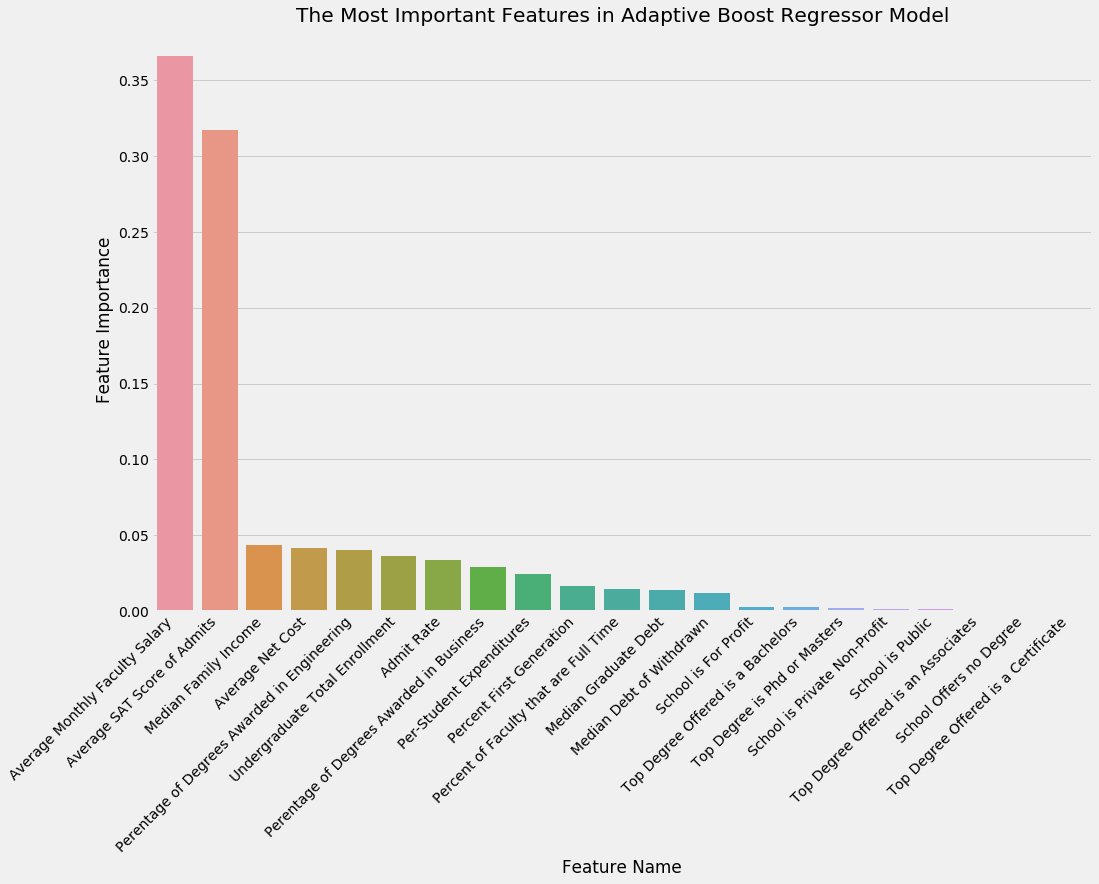

In [1552]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=45, horizontalalignment='right')
plt.title("The Most Important Features in Adaptive Boost Regressor Model")
plt.ylabel("Feature Importance")
plt.xlabel("Feature Name")
df = pd.DataFrame(columns=inputs.columns)
df = df.rename(columns={"SAT_AVG":"Average SAT Score of Admits", "COST":"Average Net Cost", "INEXPFTE":"Per-Student Expenditures", "MD_FAMINC":"Median Family Income", "PCIP14":"Perentage of Degrees Awarded in Engineering", "PCIP52":"Perentage of Degrees Awarded in Business", "PAR_ED_PCT_1STGEN":"Percent First Generation", "ADM_RATE":"Admit Rate", "PFTFAC":"Percent of Faculty that are Full Time", "WDRAW_DEBT_MDN":"Median Debt of Withdrawn", "GRAD_DEBT_MDN":"Median Graduate Debt", "GRADUATE":"Top Degree is Phd or Masters", "PRIVATE":"School is Private Non-Profit", "BACHELOR":"Top Degree Offered is a Bachelors", "PUBLIC":"School is Public", "CERTIFICATE":"Top Degree Offered is a Certificate", "ASSOCIATE":"Top Degree Offered is an Associates", "NO_DEGREE":"School Offers no Degree", "FORPROFIT":"School is For Profit", "AVGFACSAL":"Average Monthly Faculty Salary", "UGDS":"Undergraduate Total Enrollment"})
df.loc[0] = boosted_model.feature_importances_
df.sort_values(by=0, axis=1, inplace=True, ascending=False)
sns.barplot(data=df)

This result is interesting, because it implies that the most important factor in a student's future earnings is the average monthly faculty salary of the college they attend, followed closely by their SAT scores. 

In [1447]:
X_train = X_train[["SAT_AVG", "COST", "ADM_RATE", "MD_FAMINC", "INEXPFTE", "PAR_ED_PCT_1STGEN", "AVGFACSAL"]]
X_test = X_test[["SAT_AVG", "COST", "ADM_RATE", "MD_FAMINC", "INEXPFTE", "PAR_ED_PCT_1STGEN", "AVGFACSAL"]]

To reduce possible overfitting, I decided to select only the most relevant features. However, this did not seem to help my models very much. 

In [1448]:
boosted_model = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth=10), n_estimators=500, random_state=0, learning_rate=0.01)
boosted_model.fit(X_train, y_train)
print(report_rmse(boosted_model, X_train, y_train, X_test, y_test))
print(boosted_model.score(X_test, y_test))

(2259.6892170733845, 7057.1382782055925)
0.7066320514524906


In [1485]:
linear_model = LinearRegression().fit(X_train, y_train)
print(report_rmse(linear_model, X_train, y_train, X_test, y_test))
print(linear_model.score(X_test, y_test))

(7046.758292220397, 6607.45915306751)
0.7428275846522179


/Users/malcolmdevoe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 0, 'Average Monthly Faculty Salary')

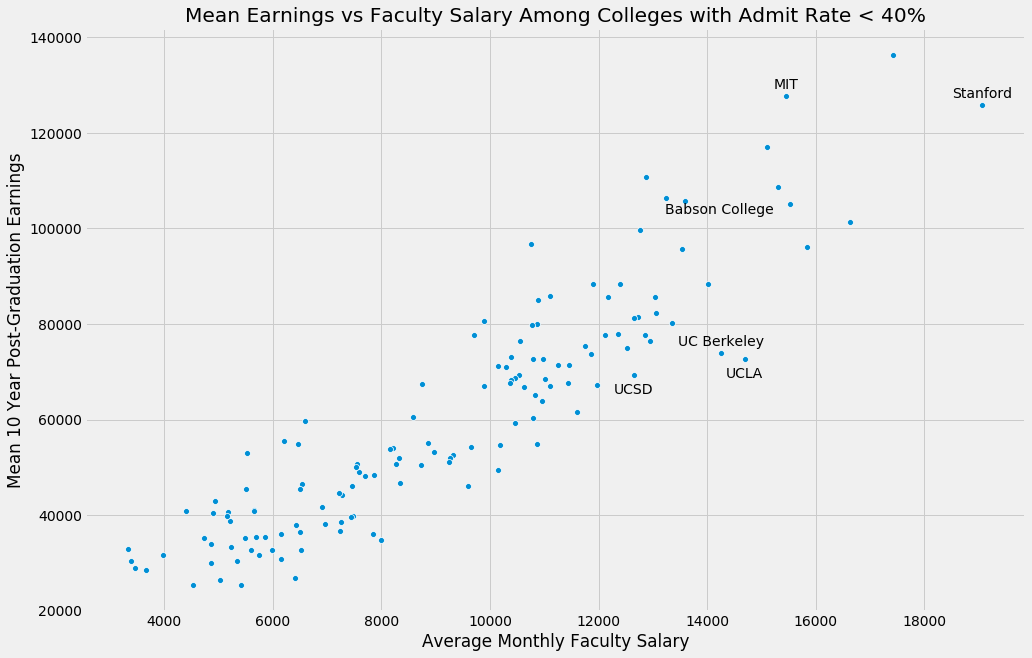

In [1553]:
some_fields_with_name_enrollment = some_fields_with_name.sort_values(by="ADM_RATE", ascending=False)
some_fields_with_name = some_fields_with_name.sort_values(by="AVGFACSAL", ascending=False)[some_fields_with_name["ADM_RATE"] < 0.4]
plt.figure(figsize=(15,10))
sns.scatterplot(x="AVGFACSAL", y="MN_EARN_WNE_P10", data=some_fields_with_name)
plt.annotate("UC Berkeley", xy=(14251.0, 74000.0), textcoords="offset points", xytext=(0,7), ha='center')
plt.annotate("UCLA", xy=(14691.0, 72600.0), textcoords="offset points", xytext=(0,-19), ha='center')
plt.annotate("Stanford", xy=(19073.0, 125900.0), textcoords="offset points", xytext=(0,7), ha='center')
plt.annotate("MIT", xy=(15459.0, 127700.0), textcoords="offset points", xytext=(0,7), ha='center')
plt.annotate("UCSD", xy=(12647.0, 69400.0), textcoords="offset points", xytext=(0,-19), ha='center')
plt.annotate("Babson College", xy=(13586.0, 105700.0), textcoords="offset points", xytext=(-20,-13), ha='left')
plt.title("Mean Earnings vs Faculty Salary Among Colleges with Admit Rate < 40%")
plt.ylabel("Mean 10 Year Post-Graduation Earnings")
plt.xlabel("Average Monthly Faculty Salary")

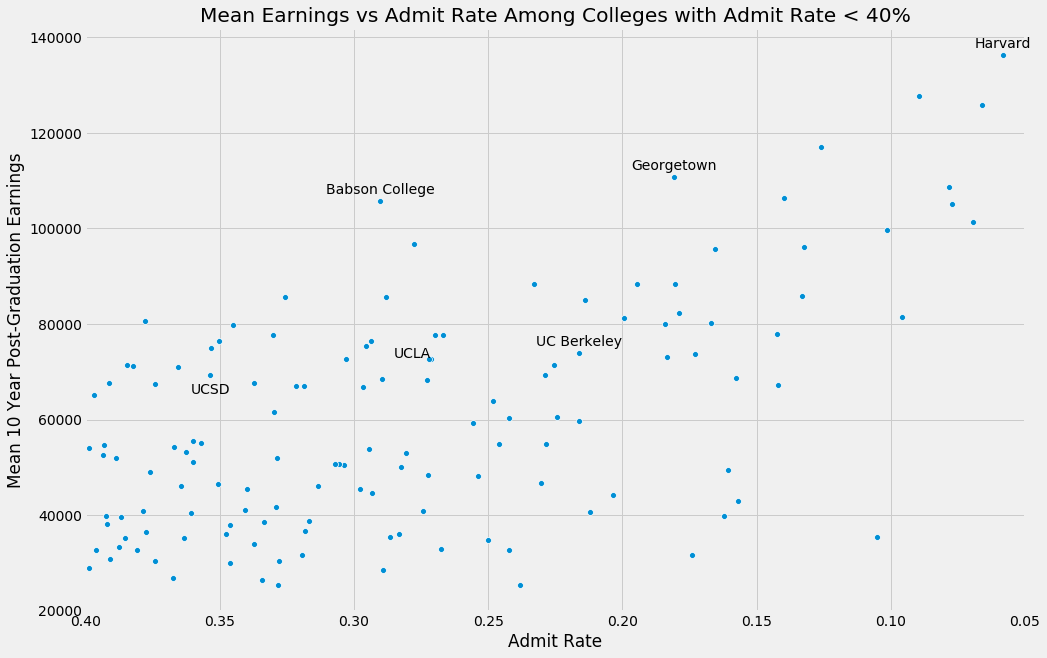

In [1554]:
some_fields_with_name.sort_values(by="ADM_RATE", ascending=True)
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim(0.4, 0.05)
sns.scatterplot(x="ADM_RATE", y="MN_EARN_WNE_P10", data=some_fields_with_name)
plt.annotate("Babson College", xy=(0.2901, 105700.0), textcoords="offset points", xytext=(0,7), ha='center')
plt.annotate("UC Berkeley", xy=(0.2161, 74000.0), textcoords="offset points", xytext=(0,7), ha='center')
plt.annotate("Harvard", xy=(0.0581, 136400.0), textcoords="offset points", xytext=(0,7), ha='center')
plt.annotate("UCSD", xy=(0.3535, 69400.0), textcoords="offset points", xytext=(0,-19), ha='center')
plt.annotate("UCLA", xy=(0.2711, 72600.0), textcoords="offset points", xytext=(0,1), ha='right')
plt.annotate("Georgetown", xy=(0.1807, 110800.0), textcoords="offset points", xytext=(0,7), ha='center')
plt.title("Mean Earnings vs Admit Rate Among Colleges with Admit Rate < 40%")
plt.ylabel("Mean 10 Year Post-Graduation Earnings")
plt.xlabel("Admit Rate")
plt.show()

Admit rate seems to be a bit less correlated with mean earnings, as shown in the Ada-Boost feature importance chart. There are some outliers, like Babson College, which appears to be almost entirely focused on business majors.

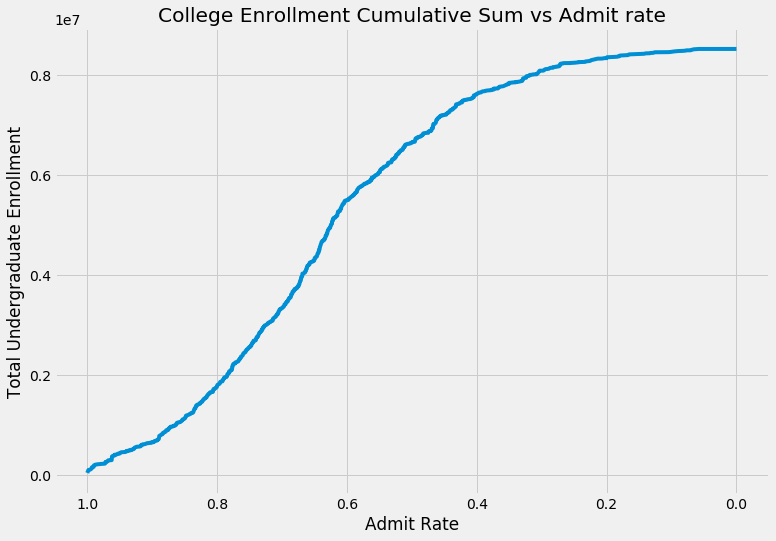

In [1484]:
data = data.sort_values(by="ADM_RATE", ascending=False)
undergrads = data["UGDS"].cumsum()
admit_rates = data["ADM_RATE"]
plt.figure(figsize=(11.4,8))
plt.gca().invert_xaxis()
sns.lineplot(x=admit_rates, y=undergrads)
plt.title("College Enrollment Cumulative Sum vs Admit rate")
plt.ylabel("Total Undergraduate Enrollment")
plt.xlabel("Admit Rate")
plt.show()

# Further Discussion

I learned that the overwhelming of college students in the US go to colleges with a >40% acceptance rate, and that which school you attend does matter a lot; much more than SAT scores or family income. Average faculty salary seems like a measure that is much more difficult to game than other measures such as admit rate. Also, it probably serves as a proxy for college location, and colleges in cities probably produce better results. I was expecting to see that SAT scores or family income would be good predictors or future income, since both are traditionally viewed as good predictors of that. One flaw in the features is that it does not include a student's high school g.p.a, which may also be a significant factor, similar to SAT scores

Now that I better grasp the process of setting up machine learning models, I would like to further examine how much major choice matters in attending a college. It could be that colleges with majors that are more focused on relatively higher paying fields, such as engineering, outperform their more prestigious counterparts where people major in a larger variety of fields. Or colleges that are more highly ranked may still win out. Further research into college outcomes is probably needed with respect the broader field of study. Because despite the numerous issues related to access, diversity, and quality of education that colleges face, they remain one of the best ways for any person to achieve lifelong upward social mobility. 